In [414]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [415]:
import tensorflow as tf
import tensorflow_probability as tfp
from check_shapes import check_shapes
from matplotlib.axes import Axes

import gpflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [416]:
## Solar radiance
series = pd.read_csv('../data/time_series_solar.csv', index_col="Datetime", parse_dates=True) 

In [419]:
print(series)

Datetime
2007-10-01 00:00:00    0.0
2007-10-01 01:00:00    0.0
2007-10-01 02:00:00    0.0
2007-10-01 03:00:00    0.0
2007-10-01 04:00:00    0.0
                      ... 
2013-09-30 19:00:00    0.0
2013-09-30 20:00:00    0.0
2013-09-30 21:00:00    0.0
2013-09-30 22:00:00    0.0
2013-09-30 23:00:00    0.0
Name: Incoming Solar, Length: 52608, dtype: float64


In [420]:
# Resample the data to daily frequency
series = series.resample('D').sum()

In [421]:
series_df = series.reset_index()
plt.rcParams['figure.figsize'] = [12, 6]

In [422]:
#series_df.iloc[0:27]

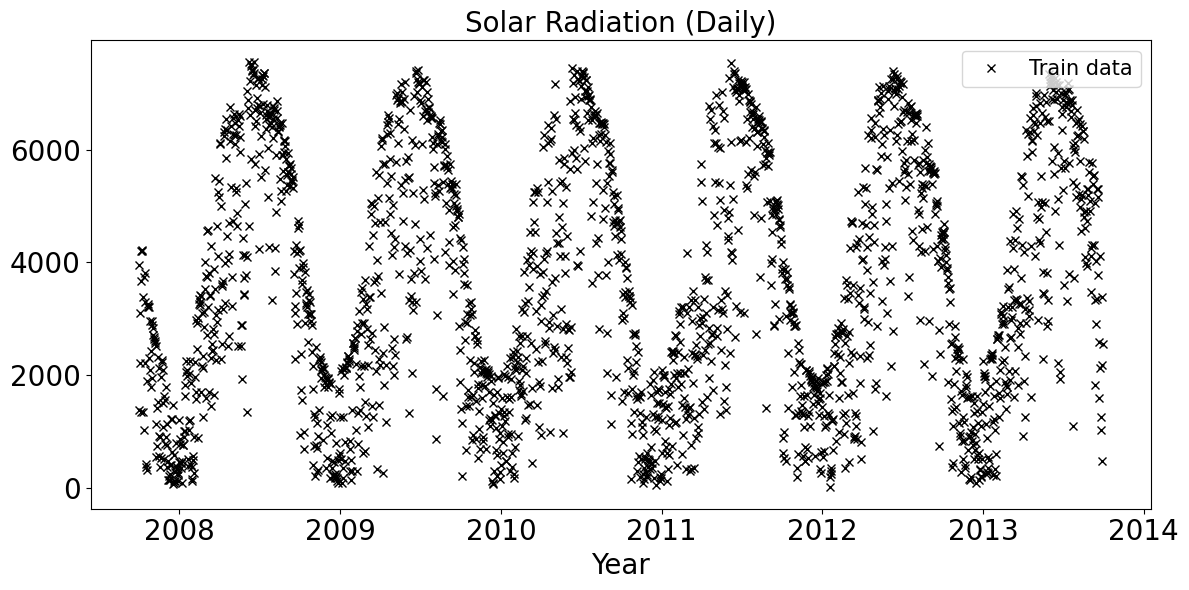

In [423]:
# Plot the data
_, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(series_df['Datetime'], series_df['Incoming Solar'], 'kx', label='Train data')

plt.legend()
plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation (Daily)', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()
#plt.xlim(1986, 2024)

plt.savefig('solar_radiation.png')
#plt.show()

### Normalize Data 

In [424]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)

    return agg


In [425]:
data = series_to_supervised(series, 0)
print(data)

            var1(t)
Datetime           
2007-10-01   1381.5
2007-10-02   3953.2
2007-10-03   3098.1
2007-10-04   2213.9
2007-10-05   1338.8
...             ...
2013-09-26   1034.2
2013-09-27   2182.3
2013-09-28   3384.5
2013-09-29    478.2
2013-09-30   2554.8

[2192 rows x 1 columns]


In [426]:
# ---
scaler = MinMaxScaler(feature_range=(-1, 1))
train, test = train_test_split(data, test_size=0.2, shuffle=False)
train = scaler.fit_transform(train)
test = scaler.transform(test)

X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [427]:
data

,var1(t)
Datetime,
2007-10-01,1381.5
2007-10-02,3953.2
2007-10-03,3098.1
2007-10-04,2213.9
2007-10-05,1338.8
...,...
2013-09-26,1034.2
2013-09-27,2182.3
2013-09-28,3384.5


In [428]:
time = data.index
time_train, time_test = train_test_split(time, test_size=0.2, shuffle=False)

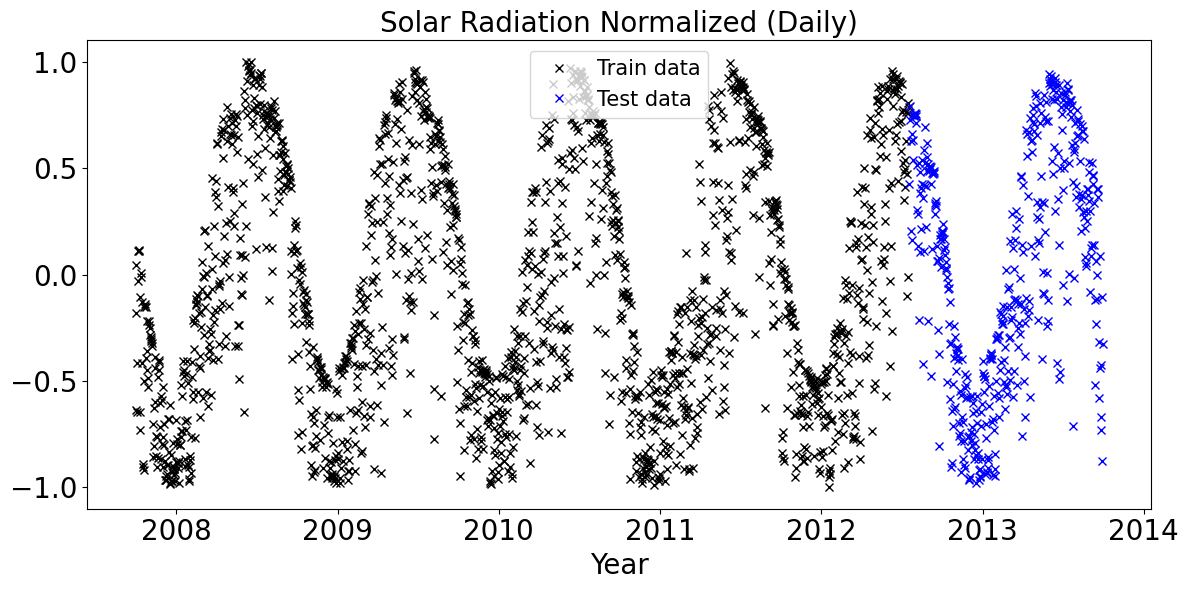

In [429]:
# Plot the data
_, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(time_train, y_train, 'kx', label='Train data')
ax.plot(time_test, y_test, 'bx', label='Test data')

plt.legend()
plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation Normalized (Daily)', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()
#plt.xlim(1986, 2024)

plt.savefig('solar_radiation_normalized.png')
#plt.show()

In [430]:
series.index

DatetimeIndex(['2007-10-01', '2007-10-02', '2007-10-03', '2007-10-04',
               '2007-10-05', '2007-10-06', '2007-10-07', '2007-10-08',
               '2007-10-09', '2007-10-10',
               ...
               '2013-09-21', '2013-09-22', '2013-09-23', '2013-09-24',
               '2013-09-25', '2013-09-26', '2013-09-27', '2013-09-28',
               '2013-09-29', '2013-09-30'],
              dtype='datetime64[ns]', name='Datetime', length=2192, freq='D')

In [431]:
dates_series = pd.Series(data.index)

# Determine the number of days in each year
days_in_year = np.where(dates_series.dt.is_leap_year, 366, 365)

# Calculate decimal year
decimal_years = dates_series.dt.year + (dates_series.dt.dayofyear - 1) / days_in_year

# Print the result
print(decimal_years)

0       2007.747945
1       2007.750685
2       2007.753425
3       2007.756164
4       2007.758904
           ...     
2187    2013.734247
2188    2013.736986
2189    2013.739726
2190    2013.742466
2191    2013.745205
Name: Datetime, Length: 2192, dtype: float64


In [432]:
decimal_years_train, decimal_years_test = train_test_split(decimal_years, test_size=0.2, shuffle=False)

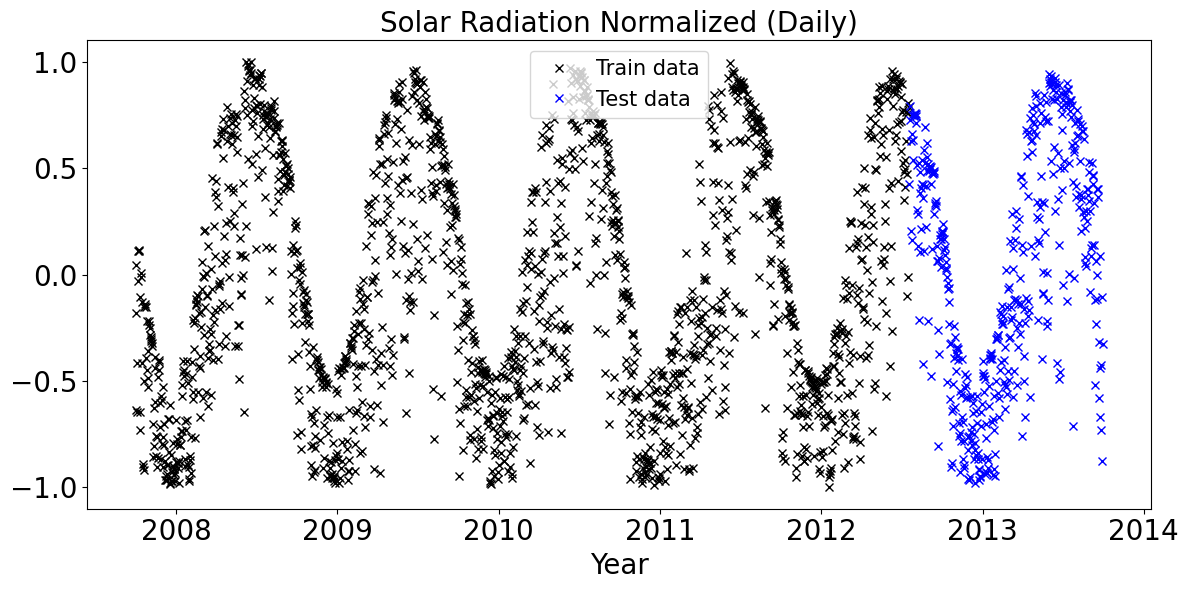

In [433]:
# Plot the data
_, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(decimal_years_train, y_train, 'kx', label='Train data')
ax.plot(decimal_years_test, y_test, 'bx', label='Test data')

plt.legend()
plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation Normalized (Daily)', fontsize=20)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()
#plt.xlim(1986, 2024)

plt.savefig('solar_radiation_normalized_decimal.png')
#plt.show()

### Fit a Gaussian process regression

In [1]:
import gpflow

2024-11-06 15:47:38.692504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730904458.730683   37494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730904458.740130   37494 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 15:47:38.765638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X = decimal_years_train.to_numpy().reshape(-1,1)
Y = y_train.reshape(-1,1)

NameError: name 'decimal_years_train' is not defined

In [ ]:
Xtest = decimal_years_test.to_numpy().reshape(-1,1)
Ytest = y_test.reshape(-1,1)

In [ ]:
#k = gpflow.kernels.SquaredExponential()
k = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(), period=2.0) #+ gpflow.kernels.Matern12()

In [ ]:
model = gpflow.models.GPR(
    (X, Y),
    kernel=k,
)

In [ ]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 15043.835353395152
        x: [ 1.864e+00 -9.142e-01  4.801e+05  1.634e+06]
      nit: 68
      jac: [-9.371e-01 -1.879e-01 -1.652e-04  4.846e-05]
     nfev: 87
     njev: 87
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [398]:
f_mean_train, f_var_train = model.predict_f(X, full_cov=False)
y_mean_train, y_var_train = model.predict_y(X)

In [399]:
f_mean_test, f_var_test = model.predict_f(Xtest, full_cov=False)
y_mean_test, y_var_test = model.predict_y(Xtest)

In [400]:
f_lower_train = f_mean_train - 1.96 * np.sqrt(f_var_train)
f_upper_train = f_mean_train + 1.96 * np.sqrt(f_var_train)
y_lower_train = y_mean_train - 1.96 * np.sqrt(y_var_train)
y_upper_train = y_mean_train + 1.96 * np.sqrt(y_var_train)

In [401]:
f_lower_test = f_mean_test - 1.96 * np.sqrt(f_var_test)
f_upper_test = f_mean_test + 1.96 * np.sqrt(f_var_test)
y_lower_test = y_mean_test - 1.96 * np.sqrt(y_var_test)
y_upper_test = y_mean_test + 1.96 * np.sqrt(y_var_test)

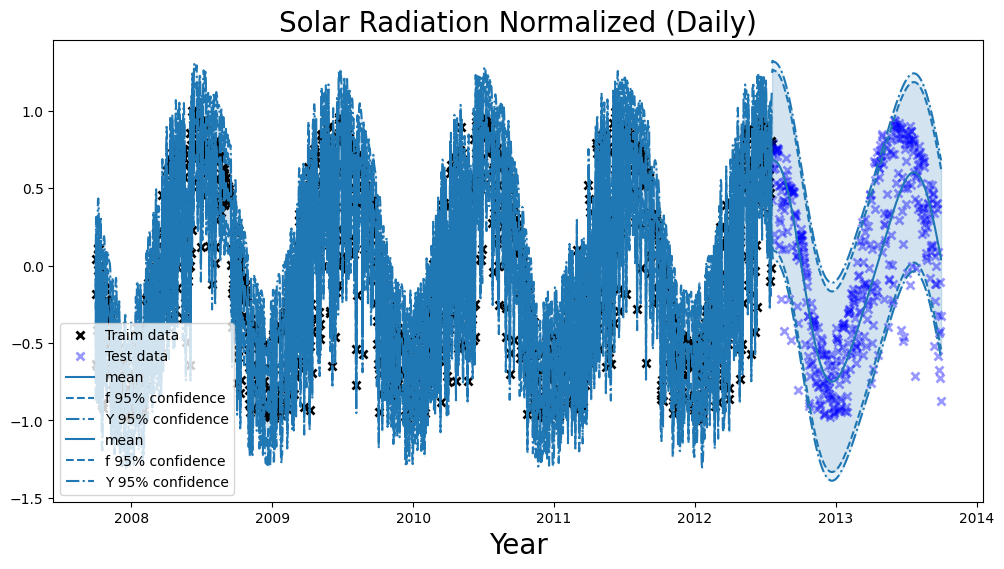

In [402]:
plt.plot(X, Y, "kx", mew=2, label="Traim data")
plt.plot(Xtest, Ytest, "bx", mew=2, label="Test data", alpha=0.4)

plt.plot(X, f_mean_train, "-", color="C0", label="mean")

plt.plot(X, f_lower_train, "--", color="C0", label="f 95% confidence")
plt.plot(X, f_upper_train, "--", color="C0")
plt.fill_between(
    X[:, 0], f_lower_train[:, 0], f_upper_train[:, 0], color="C0", alpha=0.1
)
plt.plot(X, y_lower_train, "-.", color="C0", label="Y 95% confidence")
plt.plot(X, y_upper_train, "-.", color="C0")
plt.fill_between(
    X[:, 0], y_lower_train[:, 0], y_upper_train[:, 0], color="C0", alpha=0.1
)

plt.plot(Xtest, f_mean_test, "-", color="C0", label="mean")

plt.plot(Xtest, f_lower_test, "--", color="C0", label="f 95% confidence")
plt.plot(Xtest, f_upper_test, "--", color="C0")
plt.fill_between(
    Xtest[:, 0], f_lower_test[:, 0], f_upper_test[:, 0], color="C0", alpha=0.1
)
plt.plot(Xtest, y_lower_test, "-.", color="C0", label="Y 95% confidence")
plt.plot(Xtest, y_upper_test, "-.", color="C0")
plt.fill_between(
    Xtest[:, 0], y_lower_test[:, 0], y_upper_test[:, 0], color="C0", alpha=0.1
)

plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation Normalized (Daily)', fontsize=20)


plt.legend(loc='lower left')

In [403]:
# Calculate MSE
mse = mean_squared_error(y_test , f_mean_test.numpy())
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1078684370079135


In [413]:
gpflow.utilities.print_summary(model)

╒═════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════╕
│ name                                │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │            value │
╞═════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════╡
│ GPR.kernel.base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 480088           │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      0.337059    │
├─────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────┤
│ GPR.kernel.period                   │ Parameter │ Softplus  

### Go back to original scale

In [404]:
Y = scaler.inverse_transform(Y)
Ytest = scaler.inverse_transform(Ytest)

f_mean_train = scaler.inverse_transform(f_mean_train)
f_var_train = scaler.inverse_transform(f_var_train)
y_mean_train = scaler.inverse_transform(y_mean_train)
y_var_train = scaler.inverse_transform(y_var_train)

f_mean_test = scaler.inverse_transform(f_mean_test)
f_var_test = scaler.inverse_transform(f_var_test)
y_mean_test = scaler.inverse_transform(y_mean_test)
y_var_test = scaler.inverse_transform(y_var_test)

f_lower_train = scaler.inverse_transform(f_lower_train)
f_upper_train = scaler.inverse_transform(f_upper_train)
y_lower_train = scaler.inverse_transform(y_lower_train)
y_upper_train = scaler.inverse_transform(y_upper_train)

f_lower_test = scaler.inverse_transform(f_lower_test)
f_upper_test = scaler.inverse_transform(f_upper_test)
y_lower_test = scaler.inverse_transform(y_lower_test)
y_upper_test = scaler.inverse_transform(y_upper_test)

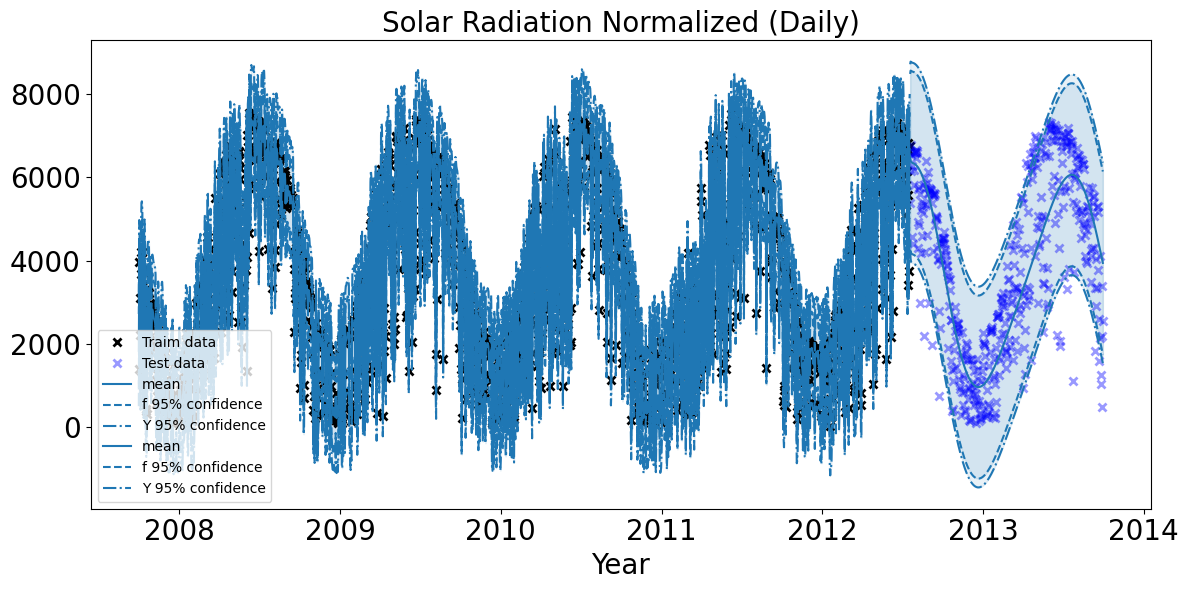

In [407]:
plt.plot(X, Y, "kx", mew=2, label="Traim data")
plt.plot(Xtest, Ytest, "bx", mew=2, label="Test data", alpha=0.4)

plt.plot(X, f_mean_train, "-", color="C0", label="mean")

plt.plot(X, f_lower_train, "--", color="C0", label="f 95% confidence")
plt.plot(X, f_upper_train, "--", color="C0")
plt.fill_between(
    X[:, 0], f_lower_train[:, 0], f_upper_train[:, 0], color="C0", alpha=0.1
)
plt.plot(X, y_lower_train, "-.", color="C0", label="Y 95% confidence")
plt.plot(X, y_upper_train, "-.", color="C0")
plt.fill_between(
    X[:, 0], y_lower_train[:, 0], y_upper_train[:, 0], color="C0", alpha=0.1
)

plt.plot(Xtest, f_mean_test, "-", color="C0", label="mean")

plt.plot(Xtest, f_lower_test, "--", color="C0", label="f 95% confidence")
plt.plot(Xtest, f_upper_test, "--", color="C0")
plt.fill_between(
    Xtest[:, 0], f_lower_test[:, 0], f_upper_test[:, 0], color="C0", alpha=0.1
)
plt.plot(Xtest, y_lower_test, "-.", color="C0", label="Y 95% confidence")
plt.plot(Xtest, y_upper_test, "-.", color="C0")
plt.fill_between(
    Xtest[:, 0], y_lower_test[:, 0], y_upper_test[:, 0], color="C0", alpha=0.1
)

plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation Normalized (Daily)', fontsize=20)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()


plt.legend(loc='lower left')

plt.savefig("solar_forecast_gp1.png")

In [406]:
# Calculate MSE
mse = mean_squared_error(y_test.flatten() , f_mean_test.flatten())
print("Mean Squared Error:", mse)

Mean Squared Error: 18107239.26475826


### Taking sequential observations into account to generate forecast

In [347]:
# Save the current model parameters
kernel_params = gpflow.utilities.read_values(model.kernel)
likelihood_params = gpflow.utilities.read_values(model.likelihood)

In [348]:
X_test_new = Xtest.copy()
Y_test_new = Ytest.copy()

In [349]:
y_forecast_mean = []
y_forecast_lower = []
y_forecast_upper = []
X_plot = []

In [350]:
mse_all = []

In [351]:
horizon = 1

In [352]:
# Loop to compute MSE over the test set 

for i in range(len(X_test_new)):
    print(i)
    #try:
    X_new = np.concatenate((X, Xtest[i].reshape(-1,1)))
    Y_new = np.concatenate((Y, Ytest[i].reshape(-1,1)))

    X_test_new = np.delete(X_test_new, 0)
    Y_test_new = np.delete(Y_test_new, 0)

    model_new = gpflow.models.GPR(
        (X_new, Y_new),
        kernel=k,
        likelihood=gpflow.likelihoods.Gaussian())

    gpflow.utilities.multiple_assign(model_new.kernel, kernel_params)
    gpflow.utilities.multiple_assign(model_new.likelihood, likelihood_params)

    X_eval = X_test_new[horizon].reshape(-1,1)
    Y_eval = Y_test_new[horizon].reshape(-1,1)

    y_mean, y_var = model.predict_y(X_eval, full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    mse_y = (Y_eval - y_mean)**2

    mse_all.append(mse_y)

    y_forecast_mean.append(y_mean)
    y_forecast_lower.append(y_lower)
    y_forecast_upper.append(y_upper)
    
    X_plot.append(X_eval)
    #except: 
    #    ('Reched end of sample')
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: index 1 is out of bounds for axis 0 with size 1

In [362]:
mse_all = np.array(mse_all).flatten().reshape(-1,1)
y_forecast_mean = np.array(y_forecast_mean).flatten().reshape(-1,1)
y_forecast_lower = np.array(y_forecast_lower).flatten().reshape(-1,1)
y_forecast_upper = np.array(y_forecast_upper).flatten().reshape(-1,1)
X_plot = np.array(X_plot).flatten().reshape(-1,1)

Y = scaler.inverse_transform(Y)
Ytest = scaler.inverse_transform(Ytest)

y_forecast_mean = scaler.inverse_transform(y_forecast_mean)
y_forecast_lower = scaler.inverse_transform(y_forecast_lower)
y_forecast_upper = scaler.inverse_transform(y_forecast_upper)

df_results = pd.DataFrame(np.concatenate([mse_all, y_forecast_mean, y_forecast_lower, y_forecast_upper, X_plot], axis=1))


In [363]:
df_results.columns = ['mse_all', 'y_forecast_mean', 'y_forecast_lower', 'y_forecast_upper', 'X_plot']

In [364]:
df_results

,mse_all,y_forecast_mean,y_forecast_lower,y_forecast_upper,X_plot
0,4.584391e+07,6377.621044,3974.820015,8780.422072,2012.551913
1,3.774526e+07,6361.567851,3951.859593,8771.276109,2012.554645
2,2.076643e+07,6353.857358,3942.323364,8765.391351,2012.557377
3,3.948891e+07,6349.349278,3937.211075,8761.487480,2012.560109
4,1.933995e+07,6345.724501,3933.317006,8758.131996,2012.562842
...,...,...,...,...,...
432,1.069372e+06,4143.946152,1730.740275,6557.152029,2013.734247
433,4.762075e+06,4093.635514,1680.519590,6506.751439,2013.736986
434,1.145438e+07,4043.102656,1630.077777,6456.127534,2013.739726
435,2.286224e+05,3992.370608,1579.437742,6405.303474,2013.742466


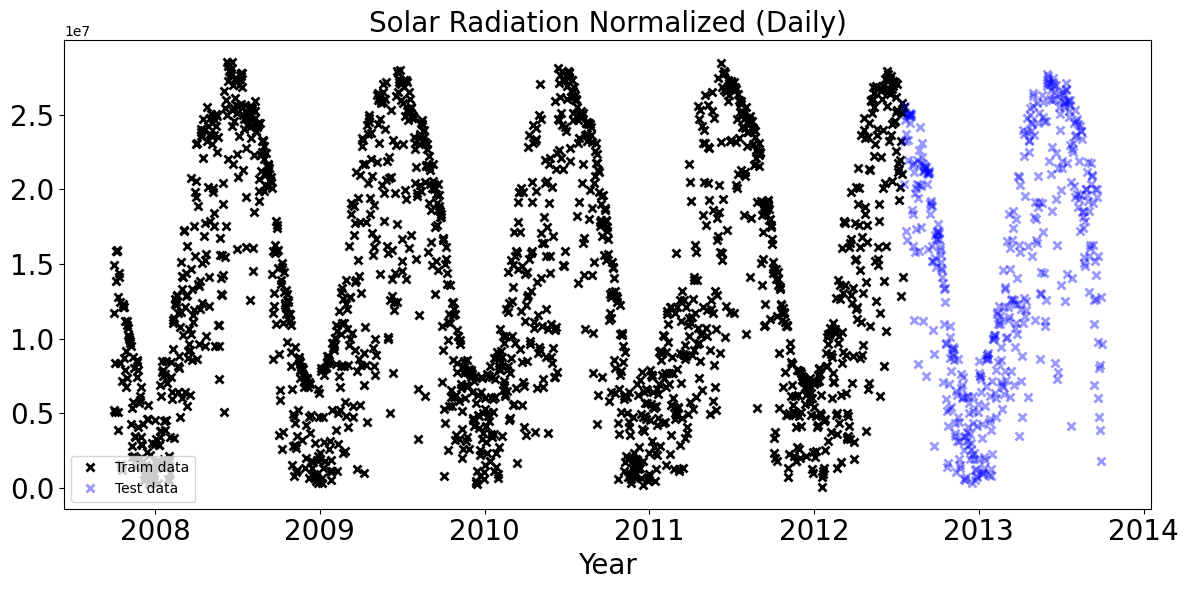

In [367]:
plt.plot(X, Y, "kx", mew=2, label="Traim data")
plt.plot(Xtest, Ytest, "bx", mew=2, label="Test data", alpha=0.4)

# plt.plot(X, f_mean_train, "-", color="C0", label="mean")

# plt.plot(X, f_lower_train, "--", color="C0", label="f 95% confidence")
# plt.plot(X, f_upper_train, "--", color="C0")
# plt.fill_between(
#     X[:, 0], f_lower_train[:, 0], f_upper_train[:, 0], color="C0", alpha=0.1
# )
# plt.plot(X, y_lower_train, "-.", color="C0", label="Y 95% confidence")
# plt.plot(X, y_upper_train, "-.", color="C0")
# plt.fill_between(
#     X[:, 0], y_lower_train[:, 0], y_upper_train[:, 0], color="C0", alpha=0.1
# )

#plt.plot(df_results['X_plot'], df_results['y_forecast_mean'], "-", color="C0", label="mean")

#plt.plot(Xtest, f_lower_test, "--", color="C0", label="f 95% confidence")
#plt.plot(Xtest, f_upper_test, "--", color="C0")
#plt.fill_between(
#    Xtest[:, 0], f_lower_test[:, 0], f_upper_test[:, 0], color="C0", alpha=0.1
#)
# plt.plot(Xtest, y_lower_test, "-.", color="C0", label="Y 95% confidence")
# plt.plot(Xtest, y_upper_test, "-.", color="C0")
# plt.fill_between(
#     Xtest[:, 0], y_lower_test[:, 0], y_upper_test[:, 0], color="C0", alpha=0.1
# )

plt.xlabel('Year', fontsize=20)
plt.title('Solar Radiation Normalized (Daily)', fontsize=20)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.legend(fontsize=15)
plt.tight_layout()


plt.legend(loc='lower left')

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=1)

(mean_line,) = ax.plot(Xplot_train, y_mean_train, "-")
color = mean_line.get_color()

#ax.plot(Xplot_train, y_lower_train, lw=0.1, color=color)
#ax.plot(Xplot_train, y_upper_train, lw=0.1, color=color)
#ax.fill_between(
#     Xplot_train.flatten(), y_lower_train[:, 0], y_upper_train[:, 0], color=color, alpha=0.1
# )

(mean_line,) = ax.plot(df_results['X_plot'], df_results['y_forecast_mean'], "-", color='purple')
color = mean_line.get_color()
ax.plot(df_results['X_plot'], df_results['y_forecast_lower'], lw=0.1, color=color)
ax.plot(df_results['X_plot'], df_results['y_forecast_upper'], lw=0.1, color=color)

ax.fill_between(
      df_results['X_plot'], df_results['y_forecast_lower'], df_results['y_forecast_upper'], color=color, alpha=0.1
  )

ax.plot(X_test,Y_test, 'kx', label='Test data', alpha=0.4)
ax.plot(X, Y, 'bx', label='Train data', alpha=0.4)

plt.legend()
plt.xlabel('Year', fontsize=12)

# # # Also plot the inducing variables if possible:
# # iv = getattr(model, "inducing_variable", None)
# # if iv is not None:
# #     ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

#plt.legend(fontsize=15)
plt.tight_layout()



plt.savefig('Forecast_horizon_'+str(horizon)+'.png')

plt.show()